# UBSolver
This notebook contains our solution for the Entity Resolution Challenge at LauzHack 2024.
## Training
### Libraries import and data loading

In [ ]:
# Import libraries
import pandas as pd
from tqdm import tqdm
import re
import geopandas as gpd
from rapidfuzz import process, fuzz
from tqdm import tqdm
from Levenshtein import ratio  # Using ratio instead of distance
from tqdm import tqdm

In [31]:
# Data loading
df_train_original = pd.read_csv('data/external_parties_train.csv')
df_train = df_train_original.drop(columns=['external_id'])
df_train.head(5)

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone
0,04ff0d1c680189e3a80c92d86407f0f5,BENE,mary mith 107 107 angela brooks n. thomasfurt ...,mary mith,angela brooks,107 107,NaN,NaN,n. thomasfurt,NaN,bulgaria,GB49MYOB82127728573340,+1.815660-6791x8486
1,439ab0ad7380e6135ab2ff3fddd4a727,ORG,yesneia kim north michael 93971 koribati,yesneia kim,north michael,NaN,NaN,93971,koribati,NaN,NaN,NaN,0 (269)620-8734x2349
2,00cac12d41191a84f9e31aa731a83512,ORG,w. roberson jr. 41010 rachel crossingapt. 923 ...,w. roberson jr.,rachel crossingapt.,41010 923,NaN,p2235417,thompsonshire amyport,NaN,NaN,GB08OTHR53515837682953,NaN
3,e4fba5f878dd3453e35973605a783a16,BENE,azquez-nelson co. suarez ports suite & 024 bri...,azquez-nelson co.,ports suite &,NaN,NaN,NaN,brittanyberg,NaN,bulgaria bulgaria,GB17VVGW66321494633280,NaN
4,d03d7e4c31878b0255d39e8c3f0ab625,ORG,m.j. bytd iii 856 john lake s. glenn cocos (ke...,m.j. bytd iii,john lake s. glenn,856,NaN,125838276,cocos (keeling),islands,NaN,NaN,(260)3371534


In [32]:
df_test = pd.read_csv('data/external_parties_test.csv')
df_test.head(5)

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone
0,8f71ed0a819236b141978defe9a98700,BENE,therese humphrey 6223 john brokos wilvoxside 7...,therese humphrey,john brokos,6223,NaN,275897045,wilvoxside,NaN,NaN,NaN,NaN
1,dc9be336b81b971c04ca98ccdf99d51e,ORG,holly dudley 1151 doug las islands danniellesi...,holly dudley,doug las islands danniellesie,1151,NaN,72672946,lewisburgh,NaN,NaN,GB17FHFZ32055696556303,(0041)8078 074491
2,29c8ed895b8a220121168158a7447773,ORG,mcfarlan dknc 74099 joseph inlet ramirezport 7...,mcfarlan dknc,joseph inlet,NaN,NaN,74099 79351,ramirezport,NaN,brazil,GB18NWMC17588581045699,NaN
3,38ee5d04ad50ddf5f6abc67017201548,BENE,jamie cooper 50019 austin light johnbury saudi...,jamie cooper,austin light,50019,NaN,p3848887,johnbury,saudi arabia,NaN,GB57DWGJ37547997137031,NaN
4,eef4f720e71bda0a6f1e7caa21a2c98c,ORG,"fernandez, frost and gonzalez 6776 thomas cres...","fernandez, frost and gonzalez",thomas crescent apt.,6776 868,NaN,80966,michaelberg new jasmine,NaN,united states minor outlying islands,NaN,NaN


### Data cleaning

In [21]:
def clean_phone_numbers(phone_numbers):
    """
    Cleans a list of phone numbers by removing 
    alphabetical characters, dashes, underscores, spaces, and plus signs, ...
    
    Args:
        phone_numbers (list of str): List of phone numbers to clean.
    
    Returns:
        list of str: Cleaned phone numbers.
    """
    cleaned_numbers = [re.sub(r'[a-zA-Z\-\_\s\+\.\,\'\^\(\)]', '', str(phone)) for phone in phone_numbers]
    return cleaned_numbers

In [22]:
def filter_country(df, column):
    # Compare each country with the list of countries in world and compute the similarity
    def get_closest_country(name):
        country = process.extract(name, world['name'], scorer=fuzz.ratio, limit=3)
        for c in country:
            if country[0][1] > 85:
                return c[0]
        return None

    # Get the list of the countries in the world
    world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
    world['name'] = world['name'].str.lower()

    # For the countries where the length is even check if the same name is repeated twice. If so fix it
    countries = df[column].dropna().unique()
    for country in countries:
        if  len(country.split(" ")) % 2 == 0:
            country_split = country.split(" ")
            if ' '.join(country_split[:len(country_split)//2]) == ' '.join(country_split[len(country_split)//2:]):
                df[column] = df[column].replace(country, ' '.join(country_split[:len(country_split)//2]))

    # Get the list of countries that are not in the world list
    countries = df[column].dropna().unique()
    remapping = {}
    to_remove = []
    for country in countries:
        results = get_closest_country(country)
        if results is not None:
            remapping[country] = results
        else:
            to_remove.append(country)

    # Remap the countries
    df[column] = df[column].replace(remapping)
    df[column] = df[column].replace(to_remove, None)

    # Return the dataframe
    return df

In [23]:
def normalize_name(name):
    # Convert to lowercase and strip whitespace
    name = name.lower().strip()
    
    # Define all patterns to remove
    patterns = {
        # Titles
        r'\b(dr\.|mr\.|mrs\.|ms\.|prof\.)\s*': '',
        # Suffixes 
        r'\s+(jr\.|sr\.|ii|iii|md|dvm)\b': '',
        # Business entities
        r'\s+(ltd|llc|inc|corp|s\.a\.r\.l\.|p\.l\.c\.|group|grp\.)\b': '',
        # Multiple spaces
        r'\s+': ' '
    }
    
    # Apply all patterns in a single pass
    for pattern, repl in patterns.items():
        name = re.sub(pattern, repl, name)
        
    return name

In [24]:
# Filter the address countries
df_train = filter_country(df_train, 'parsed_address_country')
df_train = filter_country(df_train, 'parsed_address_state')

# Merge the two columns into a state column
df_train['country'] = df_train['parsed_address_country'].fillna(df_train['parsed_address_state'])

# Clean the phone numbers
df_train['party_phone'] = clean_phone_numbers(df_train['party_phone'])

# Normalize the names
df_train['parsed_name'] = df_train['parsed_name'].apply(normalize_name)

In [25]:
# Filter the address countries
df_test = filter_country(df_test, 'parsed_address_country')
df_test = filter_country(df_test, 'parsed_address_state')

# Merge the two columns into a state column
df_test['country'] = df_test['parsed_address_country'].fillna(df_test['parsed_address_state'])

# Clean the phone numbers
df_test['party_phone'] = clean_phone_numbers(df_test['party_phone'])

# Normalize the names
df_test['parsed_name'] = df_test['parsed_name'].apply(normalize_name)

### Data preparation

In [26]:
def find_similar_pairs(df_train, excluded_columns):
    """Find similar pairs of transactions more efficiently using sets."""
    # Get columns to check
    columns_to_check = df_train.columns.drop(['transaction_reference_id'] + excluded_columns)
    
    # Use a set for faster duplicate checking
    all_pairs = set()
    
    # Process each column
    for column in tqdm(columns_to_check, desc="Processing columns"):
        # Group by column value
        groups = (
            df_train[df_train[column].notna()]  # Skip NaN values
            .groupby(column)['transaction_reference_id']
            .agg(list)
            # Filter groups: more than 1 transaction but less than 1000 to avoid combinatorial explosion
            .loc[lambda x: (x.str.len() > 1) & (x.str.len() < 1000)]
        )
        
        # Process each group
        n_pairs = 0
        for group in groups:
            # Sort once for consistent ordering
            sorted_group = sorted(group)
            group_size = len(sorted_group)
            
            # Add pairs to set (automatically handles duplicates)
            if group_size < 15:  # Safety check
                for i in range(group_size - 1):
                    for j in range(i + 1, group_size):
                        all_pairs.add((sorted_group[i], sorted_group[j]))
                n_pairs += (group_size * (group_size - 1)) // 2
                
    # Convert to DataFrame more efficiently
    similar_pairs_df = pd.DataFrame(
        list(all_pairs), 
        columns=['transaction_id_1', 'transaction_id_2']
    )
    
    return similar_pairs_df

def calculate_similarities(similar_pairs_df, df_train, excluded_columns):
    """Calculate Levenshtein similarities between pairs of transactions more efficiently."""
    # Pre-process df_train to avoid repeated lookups
    columns_to_check = df_train.columns.drop(['transaction_reference_id'] + excluded_columns)
    
    # Create lookup dictionary for faster access
    df_dict = df_train.set_index('transaction_reference_id')[columns_to_check].to_dict('index')
    
    # Initialize lists for each column to build DataFrame more efficiently
    data = {
        'transaction_id_1': [],
        'transaction_id_2': []
    }
    for col in columns_to_check:
        data[f'{col}_similarity'] = []
    
    # Process pairs
    for _, (id1, id2) in tqdm(similar_pairs_df[['transaction_id_1', 'transaction_id_2']].iterrows(), 
                             total=len(similar_pairs_df), 
                             desc="Calculating similarities"):
        # Get rows from dictionary
        row1 = df_dict[id1]
        row2 = df_dict[id2]
        
        # Add transaction IDs
        data['transaction_id_1'].append(id1)
        data['transaction_id_2'].append(id2)
        
        # Calculate similarities for each column
        for col in columns_to_check:
            val1 = str(row1[col]) if pd.notna(row1[col]) else ''
            val2 = str(row2[col]) if pd.notna(row2[col]) else ''
            sim = ratio(val1.lower(), val2.lower()) if val1 or val2 else 0
            data[f'{col}_similarity'].append(sim)
    
    # Create DataFrame from collected data
    return pd.DataFrame(data)

In [27]:
# Find the similar pairs
excluded_columns = ['party_role', 'party_info_unstructured']
similar_pairs_df = find_similar_pairs(df_train, excluded_columns)
similar_pairs_df.head(5)

Processing columns: 100%|██████████| 11/11 [00:01<00:00,  9.00it/s]


,transaction_id_1,transaction_id_2
0,c9227a105c685b47b8a6ca7d461afd89,e82cb1395a56c8abd8470daa6b727690
1,79e6783489808fa2184fecb680ef7041,99c6af880fbbf765f15de1a892267ad3
2,8320fc702fbfddb28ea172d18d494fb2,8ea16a54409bbdde4094246375b0f15f
3,2da10e0662560cf1f563b829f34a79f1,335608501e89717a172b3ab1adbf8549
4,64fe8611a59a472f4b2cec7e583cd90c,e96893c5f17f969370555752f8403474


In [28]:
# Compute similarity
excluded_columns = ['party_role', 'party_info_unstructured', 'parsed_address_country', 'parsed_address_state', 'parsed_address_street_number', 'parsed_address_postal_code', 'parsed_address_unit']
similarity_df = calculate_similarities(similar_pairs_df, df_train, excluded_columns)
similarity_df.head(5)

Calculating similarities: 100%|██████████| 22633/22633 [00:01<00:00, 16210.23it/s]


,transaction_id_1,transaction_id_2,parsed_name_similarity,parsed_address_street_name_similarity,parsed_address_city_similarity,party_iban_similarity,party_phone_similarity,country_similarity
0,c9227a105c685b47b8a6ca7d461afd89,e82cb1395a56c8abd8470daa6b727690,1.000000,0.333333,0.000000,0.454545,0.0,0.0
1,79e6783489808fa2184fecb680ef7041,99c6af880fbbf765f15de1a892267ad3,1.000000,0.344828,0.200000,0.000000,0.0,0.0
2,8320fc702fbfddb28ea172d18d494fb2,8ea16a54409bbdde4094246375b0f15f,0.206897,0.190476,1.000000,0.409091,0.0,0.0
3,2da10e0662560cf1f563b829f34a79f1,335608501e89717a172b3ab1adbf8549,1.000000,0.230769,0.142857,1.000000,0.0,0.0
4,64fe8611a59a472f4b2cec7e583cd90c,e96893c5f17f969370555752f8403474,0.320000,0.347826,1.000000,0.318182,0.0,0.0


In [33]:
# Add label based on external_id matching
labels = []
for idx, row in similarity_df.iterrows():
    # Get external_ids for both transactions
    ext_id1 = df_train_original[df_train_original['transaction_reference_id'] == row['transaction_id_1']]['external_id'].iloc[0]
    ext_id2 = df_train_original[df_train_original['transaction_reference_id'] == row['transaction_id_2']]['external_id'].iloc[0]
    
    # Set label to 1 if external_ids match, 0 otherwise
    label = 1 if (pd.notna(ext_id1) and pd.notna(ext_id2) and ext_id1 == ext_id2) else 0
    labels.append(label)

# Add labels column to similarity_df
similarity_df['label'] = labels

# Display updated dataframe
similarity_df.head(5)


,transaction_id_1,transaction_id_2,parsed_name_similarity,parsed_address_street_name_similarity,parsed_address_city_similarity,party_iban_similarity,party_phone_similarity,country_similarity,label
0,c9227a105c685b47b8a6ca7d461afd89,e82cb1395a56c8abd8470daa6b727690,1.000000,0.333333,0.000000,0.454545,0.0,0.0,0
1,79e6783489808fa2184fecb680ef7041,99c6af880fbbf765f15de1a892267ad3,1.000000,0.344828,0.200000,0.000000,0.0,0.0,1
2,8320fc702fbfddb28ea172d18d494fb2,8ea16a54409bbdde4094246375b0f15f,0.206897,0.190476,1.000000,0.409091,0.0,0.0,0
3,2da10e0662560cf1f563b829f34a79f1,335608501e89717a172b3ab1adbf8549,1.000000,0.230769,0.142857,1.000000,0.0,0.0,1
4,64fe8611a59a472f4b2cec7e583cd90c,e96893c5f17f969370555752f8403474,0.320000,0.347826,1.000000,0.318182,0.0,0.0,0


### Clustering

In [34]:
# Train final model on entire dataset using a neural network
from sklearn.neural_network import MLPClassifier

# Split data into features and target
X = similarity_df.drop(['transaction_id_1', 'transaction_id_2', 'label'], axis=1)
y = similarity_df['label']

# Create and train neural network
final_nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Two hidden layers
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

final_nn_model.fit(X, y);

In [35]:
def compute_clustering_metrics(df1, df2):
    """
    Compute precision, recall, and F1 score for clustering assignments
    
    Args:
        df1: DataFrame with columns [transaction_reference_id, external_id]
        df2: DataFrame with columns [transaction_reference_id, external_id]
    
    Returns:
        dict: Contains precision, recall, and F1 score
    """
    # Create dictionaries mapping transaction_id to cluster_id for both dataframes
    clusters1 = dict(zip(df1['transaction_reference_id'], df1['external_id']))
    clusters2 = dict(zip(df2['transaction_reference_id'], df2['external_id']))
    
    # Get all unique transaction IDs
    all_ids = list(clusters1.keys())
    n = len(all_ids)
    
    # Initialize counters for confusion matrix
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    # Compare all possible pairs
    for i in tqdm(range(n)):
        for j in range(i + 1, n):
            id1, id2 = all_ids[i], all_ids[j]
            
            # Check if pairs are in same cluster in both assignments
            same_cluster1 = clusters1[id1] == clusters1[id2]
            same_cluster2 = clusters2[id1] == clusters2[id2]
            
            if same_cluster1 and same_cluster2:
                true_positive += 1
            elif same_cluster1 and not same_cluster2:
                false_positive += 1
            elif not same_cluster1 and same_cluster2:
                false_negative += 1
    
    # Calculate metrics
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Preparation for submission

In [36]:

similar_pairs_df = find_similar_pairs(df_test, excluded_columns)


Processing columns: 100%|██████████| 5/5 [01:26<00:00, 17.34s/it]


In [37]:
similarity_df_test = calculate_similarities(similar_pairs_df, df_test, excluded_columns)

Calculating similarities: 100%|██████████| 3018671/3018671 [03:12<00:00, 15703.41it/s]


In [39]:
# Prepare features for prediction
feature_columns = [col for col in similarity_df.columns if col.endswith('_similarity')]

# Ensure all feature columns used during training are present in the test set
for col in feature_columns:
	if col not in similarity_df_test.columns:
		similarity_df_test[col] = 0

X_pred = similarity_df_test[feature_columns]

# Get probability predictions from the model
pred_probs = final_nn_model.predict_proba(X_pred)

# Apply threshold of 0.998 to probability predictions
threshold = 0.998
predictions = (pred_probs[:, 1] >= threshold).astype(int)

# Add predictions to the DataFrame
similarity_df_test['predicted_label'] = predictions

# Display results
similarity_df_test.head(5)

,transaction_id_1,transaction_id_2,parsed_name_similarity,parsed_address_street_name_similarity,parsed_address_city_similarity,party_iban_similarity,party_phone_similarity,country_similarity,predicted_label
0,15e6cb6eb08682da110be752083b6778,5bc90729e69dff8d89542bd7572a26f6,0.275862,1.0000,0.275862,0.000000,0.428571,0,0
1,5301ce9d6fc0190c934c1358acd08461,ca5a36dc2ccfbbe7b893c0bacaaf2b97,1.000000,0.3125,0.245614,0.000000,0.000000,0,0
2,b24aa7c343470cc75d6fa0442b74eb7d,f23a5ce9ed29fed4d35cfb1c66253f06,0.250000,0.0000,1.000000,0.272727,0.000000,0,0
3,2e1ab6dbe95e1b1c3bc304b77df23e86,fe324ec3280c35a9b990975678042db7,1.000000,0.0000,0.000000,0.363636,0.000000,0,0
4,4468e82ded0ee1d89d58e772ac3d7874,d239e35432894af49aefd17f9fed90db,0.256410,1.0000,0.266667,0.000000,0.312500,0,0


In [40]:
# Create a graph using networkx
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Add all unique transactions as nodes first
all_transactions = df_test['transaction_reference_id'].unique()
G.add_nodes_from(all_transactions)

# Add edges where predicted_label is 1
edges = similarity_df_test[similarity_df_test['predicted_label'] == 1][['transaction_id_1', 'transaction_id_2']].values.tolist()
G.add_edges_from(edges)

# Print some basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1481672
Number of edges: 616951


In [41]:
# Find all connected components
connected_components = list(nx.connected_components(G))

# Create a dictionary to map transaction IDs to their component labels
component_mapping = {}

# For connected components (groups of 2 or more nodes)
for i, component in enumerate(connected_components):
    if len(component) > 1:
        # Assign same label to all nodes in component
        for node in component:
            component_mapping[node] = i

# For isolated nodes, assign unique labels
isolated_nodes = [n for n in G.nodes() if G.degree(n) == 0]
for i, node in enumerate(isolated_nodes):
    component_mapping[node] = len(connected_components) + i

# Create DataFrame with transaction IDs and their component labels 
connected_components_df = pd.DataFrame({
    'transaction_reference_id': list(component_mapping.keys()),
    'external_id': list(component_mapping.values())
})

# Display the results
print(f"Number of connected components (excluding isolated nodes): {len([c for c in connected_components if len(c) > 1])}")
print(f"Number of isolated nodes: {len(isolated_nodes)}")
connected_components_df.head(5)


Number of connected components (excluding isolated nodes): 157704
Number of isolated nodes: 973232


,transaction_reference_id,external_id
0,e3a5263d7dcb1edf60b370cfa54718ef,1
1,dc9be336b81b971c04ca98ccdf99d51e,1
2,4a21d5917c868aac428ee1ad3ba1bfd5,1
3,caff907068d4e79dfa7c75c15ab247a5,1
4,7312d4c0ffa799ddbb245f3af214b784,1


<Axes: >

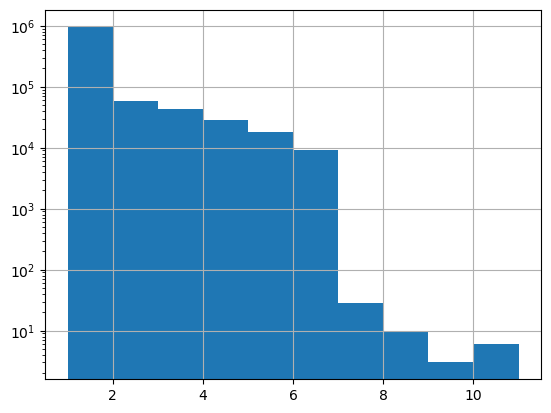

In [42]:
connected_components_df.external_id.value_counts().hist(log=True)

In [90]:
connected_components_df.to_csv('connected_components_df.csv', index=False)